In [1]:
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 100 (delta 0), reused 2 (delta 0), pack-reused 97
Receiving objects: 100% (100/100), 44.77 MiB | 5.74 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
%cd NASA-Material-Classifier

/content/NASA-Material-Classifier


In [4]:
import numpy as np
np.random.seed(1000)
import pandas as pd
import torch.nn.functional as F
import tensorflow as tf
tf.random.set_seed(1000)
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim.lr_scheduler as lr_scheduler
import scipy.io
import torch.nn as nn
from sklearn.model_selection import train_test_split
import uuid
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [5]:
file_paths = dict()
file_paths[0] = [
    "data/S11_parameter_data_for_zero_orientation.txt",
    "data/S12_parameter_data_for_zero_orientation.txt",
    "data/S21_parameter_data_for_zero_orientation.txt",
    "data/S22_parameter_data_for_zero_orientation.txt"]
file_paths[1] = [
    "data/S11_parameter_data_for_CW90_orientation.txt",
    "data/S12_parameter_data_for_CW90_orientation.txt",
    "data/S21_parameter_data_for_CW90_orientation.txt",
    "data/S22_parameter_data_for_CW90_orientation.txt"]
file_paths[2] = [
    "data/S11_parameter_data_for_CCW90_orientation.txt",
    "data/S12_parameter_data_for_CCW90_orientation.txt",
    "data/S21_parameter_data_for_CCW90_orientation.txt",
    "data/S22_parameter_data_for_CCW90_orientation.txt"]
file_paths[3] = [
    "data/S11_parameter_data_for_tilt_orientation.txt",
    "data/S12_parameter_data_for_tilt_orientation.txt",
    "data/S21_parameter_data_for_tilt_orientation.txt",
    "data/S22_parameter_data_for_tilt_orientation.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [6]:
file_paths = dict()
file_paths[0] = ["data/mea_rot_0.txt"]
file_paths[1] = ["data/mea_rot_cw90.txt"]
file_paths[2] = ["data/mea_rot_ccw90.txt"]
file_paths[3] = ["data/mea_rot_0_tilt.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [7]:
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [8]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,14958f36,1.0000000000000,0,2.2609046534204,0.04505415985025,0.010708443820477,-0.0015462124720216,0.21881757676601,0.96427404880524,0.21881759166718,0.96427410840988,0.010326976887882,-0.0032272436656058
1,14958f36,1.0006999969482,0,2.2609046534204,0.04505415985025,0.010755277238786,-0.0017734571592882,0.23742462694645,0.96046137809753,0.23742462694645,0.96046137809753,0.010342826135457,-0.0034419626463205
2,14958f36,1.0013999938965,0,2.2609046534204,0.04505415985025,0.010795198380947,-0.0020041132811457,0.25594717264175,0.95629817247391,0.25594717264175,0.95629823207855,0.010353058576584,-0.0036560846492648
3,14958f36,1.0020999908447,0,2.2609046534204,0.04505415985025,0.010827971622348,-0.0022378272842616,0.27437821030617,0.95178377628326,0.27437824010849,0.95178383588791,0.010357595048845,-0.0038695030380040
4,14958f36,1.0027999877930,0,2.2609046534204,0.04505415985025,0.010853389278054,-0.0024742297828197,0.29271024465561,0.94691836833954,0.29271024465561,0.94691836833954,0.010356365703046,-0.0040821037255228


In [9]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,aa2019dd,1.0000000000000,0,5,0.1,-0.019713426000000,-0.0060391319000000,0.99922335000000,-0.020864042000000,0.99841827000000,-0.021599129000000,0.021094969000000,-0.0067798547000000
1,aa2019dd,1.0007000000000,0,5,0.1,-0.019482541585540,-0.0063846667326036,0.99871819006375,-0.020888964080002,0.99862961142762,-0.021390875332731,0.020910906076745,-0.0072704463377855
2,aa2019dd,1.0014000000000,0,5,0.1,-0.019137625649780,-0.0065910681665272,0.99827064270063,-0.020941499353097,0.99844536227299,-0.021037567314369,0.020691122020212,-0.0077301113670862
3,aa2019dd,1.0021000000000,0,5,0.1,-0.018813112374285,-0.0069965346072957,0.99820293745227,-0.020767770604437,0.99824771176501,-0.020766027366779,0.020422204537027,-0.0081046434147131
4,aa2019dd,1.0028000000000,0,5,0.1,-0.018616413134193,-0.0076122439176546,0.99851990287783,-0.020519403197245,0.99826510603014,-0.020614971186886,0.020163732147648,-0.0083827107262601


In [10]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [11]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,14958f36,1.0000,0,2.260905,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,14958f36,1.0007,0,2.260905,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,14958f36,1.0014,0,2.260905,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,14958f36,1.0021,0,2.260905,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,14958f36,1.0028,0,2.260905,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [12]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,aa2019dd,1.0000,0,5,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,aa2019dd,1.0007,0,5,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,aa2019dd,1.0014,0,5,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,aa2019dd,1.0021,0,5,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,aa2019dd,1.0028,0,5,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [13]:
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [14]:
columns = []
for column in training_dataframe.columns:
    if column != "Permittivity_Real" and column !="Permittivity_Imaginary":
        columns.append(column)
columns

['ID',
 'Frequency',
 'Orientation',
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [15]:
testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

<ipython-input-15-45854e52fc1b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1


In [16]:
training_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,14958f36,1.0000,0,0.022609,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,14958f36,1.0007,0,0.022609,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,14958f36,1.0014,0,0.022609,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,14958f36,1.0021,0,0.022609,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,14958f36,1.0028,0,0.022609,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [17]:
testing_dataframe.head(5)

,ID,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,aa2019dd,1.0000,0,0.05,0.1,-0.019713,-0.006039,0.999223,-0.020864,0.998418,-0.021599,0.021095,-0.006780
1,aa2019dd,1.0007,0,0.05,0.1,-0.019483,-0.006385,0.998718,-0.020889,0.998630,-0.021391,0.020911,-0.007270
2,aa2019dd,1.0014,0,0.05,0.1,-0.019138,-0.006591,0.998271,-0.020941,0.998445,-0.021038,0.020691,-0.007730
3,aa2019dd,1.0021,0,0.05,0.1,-0.018813,-0.006997,0.998203,-0.020768,0.998248,-0.020766,0.020422,-0.008105
4,aa2019dd,1.0028,0,0.05,0.1,-0.018616,-0.007612,0.998520,-0.020519,0.998265,-0.020615,0.020164,-0.008383


In [18]:
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

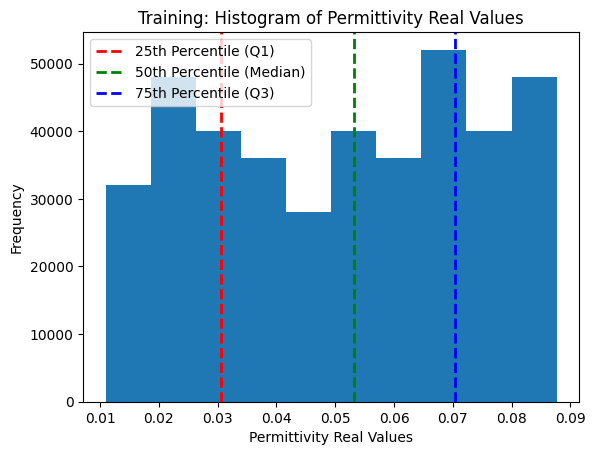

In [19]:
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

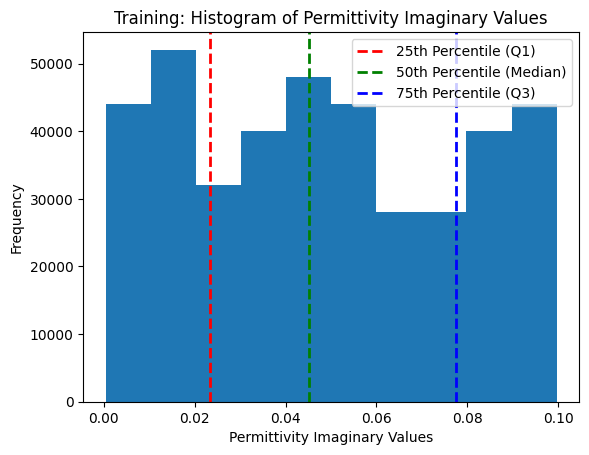

In [20]:
q25 = np.percentile(training_dataframe["Permittivity_Imaginary"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Imaginary"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Imaginary"], 75)
plt.hist(training_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Imaginary Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

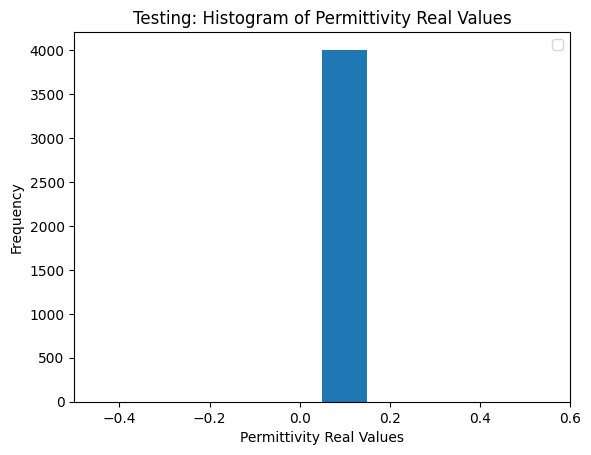

In [21]:
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

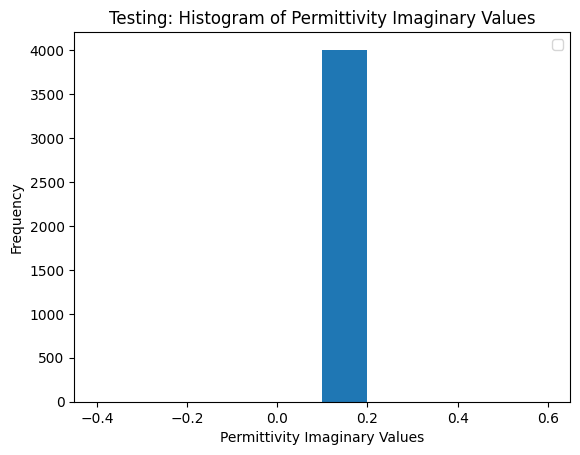

In [22]:
plt.hist(testing_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Imaginary Values")
plt.legend()
plt.show()

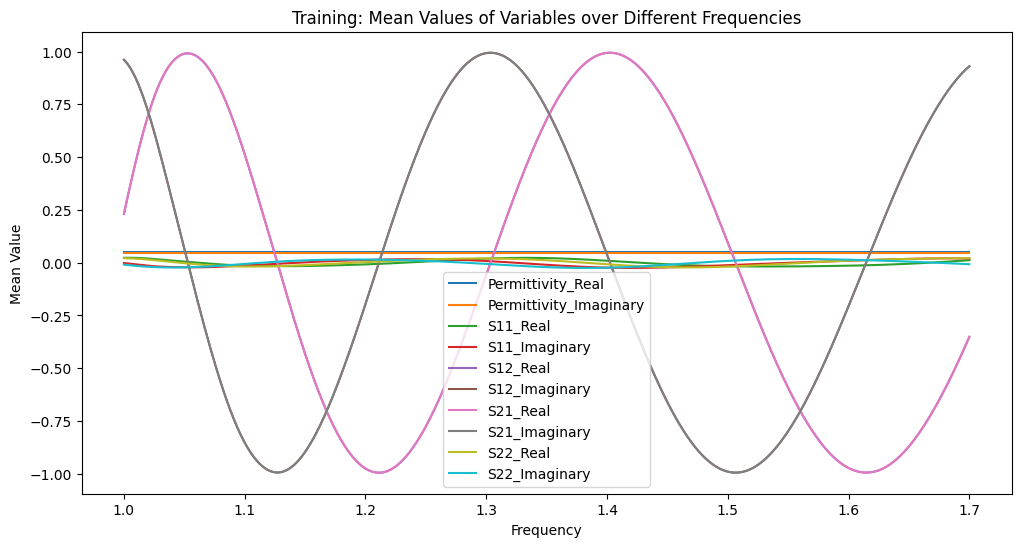

In [23]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

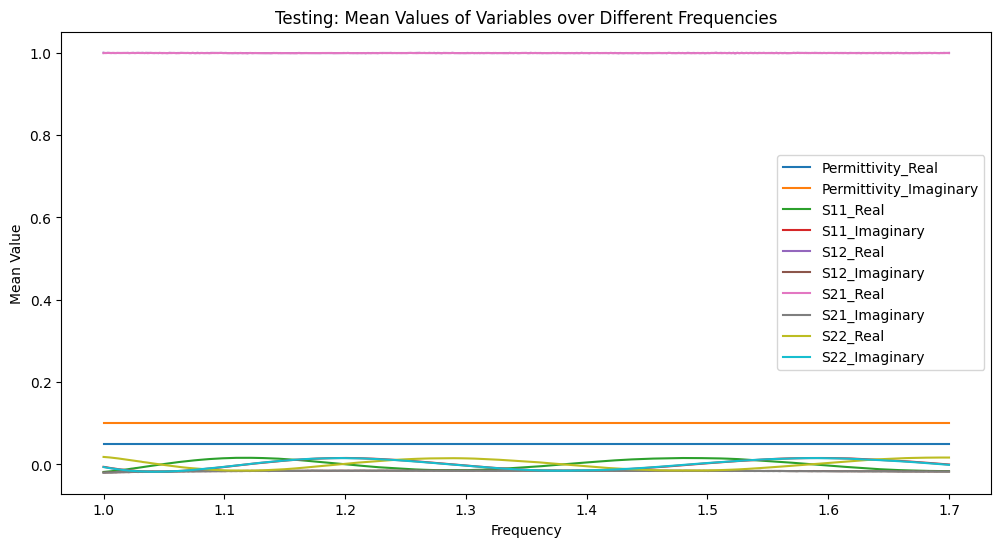

In [24]:
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Testing: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

In [25]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.groupby('ID')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.get_group(list(self.data.groups.keys())[idx])
        frequency = torch.tensor(sample['Frequency'].values, dtype=torch.float32)
        orientation = torch.tensor(sample['Orientation'].values, dtype=torch.float32)
        permittivity_real = torch.tensor(sample['Permittivity_Real'].values, dtype=torch.float32)
        permittivity_imaginary = torch.tensor(sample['Permittivity_Imaginary'].values, dtype=torch.float32)
        s11_real = torch.tensor(sample['S11_Real'].values, dtype=torch.float32)
        s11_imaginary = torch.tensor(sample['S11_Imaginary'].values, dtype=torch.float32)
        s12_real = torch.tensor(sample['S12_Real'].values, dtype=torch.float32)
        s12_imaginary = torch.tensor(sample['S12_Imaginary'].values, dtype=torch.float32)
        s21_real = torch.tensor(sample['S21_Real'].values, dtype=torch.float32)
        s21_imaginary = torch.tensor(sample['S21_Imaginary'].values, dtype=torch.float32)
        s22_real = torch.tensor(sample['S22_Real'].values, dtype=torch.float32)
        s22_imaginary = torch.tensor(sample['S22_Imaginary'].values, dtype=torch.float32)

        return (permittivity_real, permittivity_imaginary,frequency, orientation,
                s11_real, s11_imaginary, s12_real, s12_imaginary,
                s21_real, s21_imaginary, s22_real, s22_imaginary)


In [26]:
batch_size = 1
train_ids, val_ids = train_test_split(training_dataframe['ID'].unique(), test_size=0.20, random_state=1000)
train_dataset = training_dataframe[training_dataframe['ID'].isin(train_ids)]
val_dataset = training_dataframe[training_dataframe['ID'].isin(val_ids)]
train_dataloader = DataLoader(TimeSeriesDataset(train_dataset), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(TimeSeriesDataset(val_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TimeSeriesDataset(testing_dataframe), batch_size=1, shuffle=False)

In [72]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 64)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x, apply_dropout=False):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        if apply_dropout:
            x = F.dropout(x, p=0.05, training=True)
        out, _ = self.lstm(x, (h0, c0))
        context_vector = out.mean(dim=1)
        out = self.fc(context_vector)
        raw_predictions = self.fc2(self.tanh(out))
        return raw_predictions


In [73]:
input_size = 10
hidden_size = 64
num_layers = 1
output_size = 2
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

In [74]:
class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, y_true, y_pred):
        diff = y_true - y_pred
        loss = torch.log(torch.cosh(diff))
        mean_loss = torch.mean(loss)
        return mean_loss
real_loss = LogCoshLoss()
imaginary_loss = LogCoshLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [82]:
model
model.load_state_dict(torch.load('training_validation_model.pth'))

<All keys matched successfully>

In [76]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in the model: {total_params}")

Total parameters in the model: 47298


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
num_epochs = 250
train_loss = []
val_loss = []
#train_accuracy = dict()
#train_accuracy["mse"] = []
#validation_accuracy = dict()
#validation_accuracy["mse"] = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    #train_accuracy["mse"] = {}
    #train_accuracy["mse"][epoch] = 0
    for inputs in train_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)
        raw_predictions = model(input_features)
        raw_predictions_real = raw_predictions[0, 0]
        raw_predictions_imaginary = raw_predictions[0, 1]
        permittivity_real_actual = permittivity_real[0][0]
        permittivity_imaginary_actual = permittivity_imaginary[0][0]
        loss_real = real_loss(permittivity_real_actual,raw_predictions_real)
        loss_imaginary = imaginary_loss(permittivity_imaginary_actual,raw_predictions_imaginary)
        combined_loss = loss_real + loss_imaginary
        optimizer.zero_grad()
        combined_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),5)
        optimizer.step()
        total_train_loss += combined_loss.item()
        #loss_real = mse_loss(output_real_first, permittivity_real_first)
        #loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        #combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        #train_accuracy["mse"][epoch] = train_accuracy["mse"][epoch] + combined_loss
    train_loss.append(total_train_loss)
    model.eval()
    with torch.no_grad():
      total_val_loss = 0
      #validation_accuracy["mse"] = dict()
      #validation_accuracy["mse"][epoch] = 0
      for inputs in val_dataloader:
            inputs = [inp.to(device) for inp in inputs]
            permittivity_real, permittivity_imaginary, frequency, orientation, \
            s11_real, s11_imaginary, s12_real, s12_imaginary, \
            s21_real, s21_imaginary, s22_real, s22_imaginary = inputs

            input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)

            raw_predictions = model(input_features)
            raw_predictions_real = raw_predictions[0, 0]
            raw_predictions_imaginary = raw_predictions[0, 1]
            permittivity_real_actual = permittivity_real[0][0]
            permittivity_imaginary_actual = permittivity_imaginary[0][0]
            loss_real = real_loss(permittivity_real_actual,raw_predictions_real)
            loss_imaginary = imaginary_loss(permittivity_imaginary_actual,raw_predictions_imaginary)
            combined_loss = loss_real + loss_imaginary
            total_val_loss += combined_loss.item()
            #loss_real = mse_loss(output_real_first, permittivity_real_first)
            #loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
            #combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
            #validation_accuracy["mse"][epoch] = validation_accuracy["mse"][epoch] + combined_loss

    val_loss.append(total_val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader)}, Val Loss: {total_val_loss / len(val_dataloader)}')
print('Training finished.')

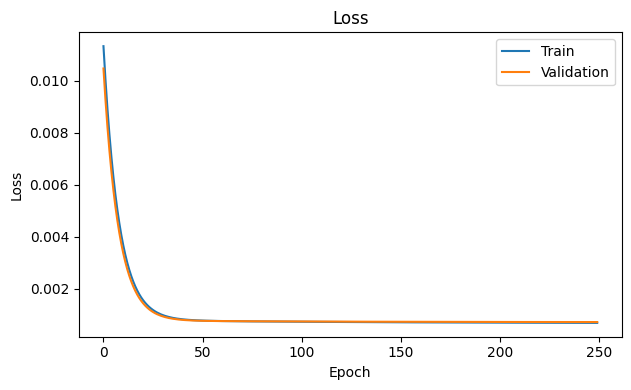

In [78]:
average_train_loss_per_sample = [loss_item / len(train_dataloader) for loss_item in train_loss]
average_val_loss_per_sample = [loss_item / len(val_dataloader) for loss_item in val_loss]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(average_train_loss_per_sample)), average_train_loss_per_sample)
plt.plot(range(len(average_val_loss_per_sample)), average_val_loss_per_sample)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [83]:
num_mc_samples = 10000
predicted_values = []
actual_values = []
probabilities_values = []
confidence_interval_dict = {}
confidence_interval_dict["real"] = {}
confidence_interval_dict["imaginary"] = {}
model.eval()

with torch.no_grad():
    for i, inputs in enumerate(test_dataloader):
        all_predictions_real = []
        all_predictions_imaginary = []
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                    orientation.unsqueeze(2),
                                    s11_real.unsqueeze(2),
                                    s11_imaginary.unsqueeze(2),
                                    s12_real.unsqueeze(2),
                                    s12_imaginary.unsqueeze(2),
                                    s21_real.unsqueeze(2),
                                    s21_imaginary.unsqueeze(2),
                                    s22_real.unsqueeze(2),
                                    s22_imaginary.unsqueeze(2)], dim=2)
        raw_predictions = model(input_features)
        raw_predictions_real = raw_predictions[0, 0]
        raw_predictions_imaginary = raw_predictions[0, 1]
        permittivity_real_actual = permittivity_real[0][0]
        permittivity_imaginary_actual = permittivity_imaginary[0][0]
        predicted_values.append((raw_predictions_real.item(), raw_predictions_imaginary.item()))
        actual_values.append((permittivity_real_actual.item(), permittivity_imaginary_actual.item()))

        for _ in range(num_mc_samples):
            boot_strap_prediction = model(input_features, apply_dropout=True)
            boot_strap_predictions_real = boot_strap_prediction[0, 0]
            boot_strap_predictions_imaginary = boot_strap_prediction[0, 1]
            all_predictions_real.append(boot_strap_predictions_real)
            all_predictions_imaginary.append(boot_strap_predictions_imaginary)

        all_predictions_real.append(raw_predictions_real)
        all_predictions_imaginary.append(raw_predictions_imaginary)
        all_predictions_real = torch.stack(all_predictions_real)
        all_predictions_imaginary = torch.stack(all_predictions_imaginary)

        mean_predictions_real = torch.mean(all_predictions_real, dim=0)
        lower_bound_real, _ = torch.kthvalue(all_predictions_real, int(0.1 * num_mc_samples), dim=0)
        upper_bound_real, _ = torch.kthvalue(all_predictions_real, int(0.90 * num_mc_samples), dim=0)

        mean_predictions_imaginary = torch.mean(all_predictions_imaginary, dim=0)
        lower_bound_imaginary, _ = torch.kthvalue(all_predictions_imaginary, int(0.1 * num_mc_samples), dim=0)
        upper_bound_imaginary, _ = torch.kthvalue(all_predictions_imaginary, int(0.90 * num_mc_samples), dim=0)

        mean_predictions_real = mean_predictions_real.detach().cpu().numpy()
        lower_bound_real = lower_bound_real.detach().cpu().numpy()
        upper_bound_real = upper_bound_real.detach().cpu().numpy()

        mean_predictions_imaginary = mean_predictions_imaginary.detach().cpu().numpy()
        lower_bound_imaginary = lower_bound_imaginary.detach().cpu().numpy()
        upper_bound_imaginary = upper_bound_imaginary.detach().cpu().numpy()

        confidence_interval_dict["real"][i] = (mean_predictions_real, lower_bound_real, upper_bound_real)
        confidence_interval_dict["imaginary"][i] = (mean_predictions_imaginary, lower_bound_imaginary, upper_bound_imaginary)

predicted_values = np.array(predicted_values)
actual_values = np.array(actual_values)

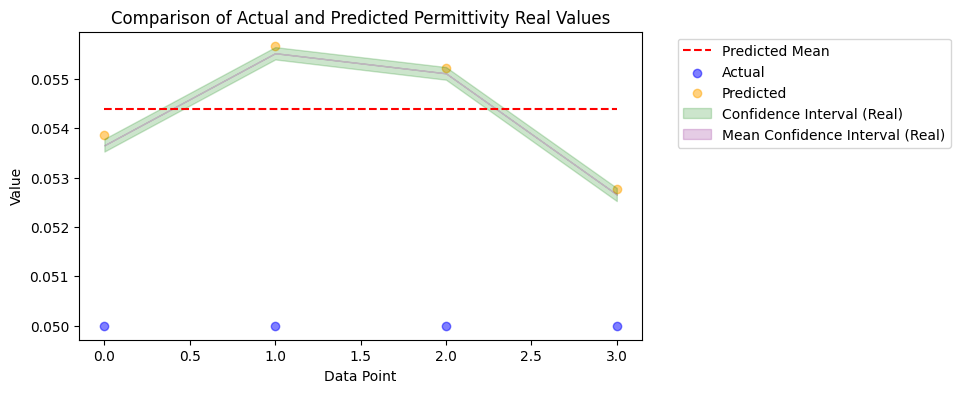

In [84]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 0]), np.mean(predicted_values[:, 0])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 0], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 0], label='Predicted', color='orange', alpha=0.5)
mean_predictions_real, lower_bound_real, upper_bound_real = zip(*confidence_interval_dict["real"].values())
mean_predictions_real = np.array(mean_predictions_real)
lower_bound_real = np.array(lower_bound_real)
upper_bound_real = np.array(upper_bound_real)
plt.fill_between(range(len(actual_values)), lower_bound_real, upper_bound_real, color='green', alpha=0.2, label='Confidence Interval (Real)')
plt.fill_between(range(len(actual_values)), mean_predictions_real, mean_predictions_real, color='purple', alpha=0.2, label='Mean Confidence Interval (Real)')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


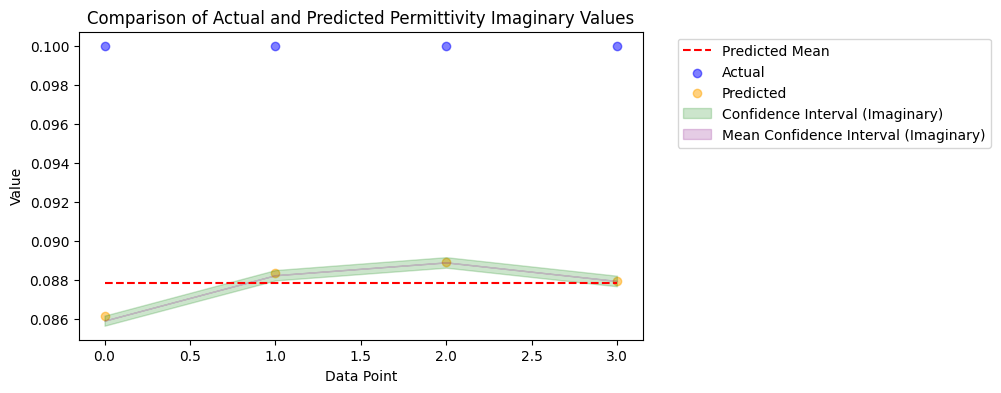

In [85]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 1]), np.mean(predicted_values[:, 1])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 1], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 1], label='Predicted', color='orange', alpha=0.5)
mean_predictions_imaginary, lower_bound_imaginary, upper_bound_imaginary = zip(*confidence_interval_dict["imaginary"].values())
mean_predictions_imaginary = np.array(mean_predictions_imaginary)
lower_bound_imaginary = np.array(lower_bound_imaginary)
upper_bound_imaginary = np.array(upper_bound_imaginary)
plt.fill_between(range(len(actual_values)), lower_bound_imaginary, upper_bound_imaginary, color='green', alpha=0.2, label='Confidence Interval (Imaginary)')
plt.fill_between(range(len(actual_values)), mean_predictions_imaginary, mean_predictions_imaginary, color='purple', alpha=0.2, label='Mean Confidence Interval (Imaginary)')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [120]:
train_dataloader = DataLoader(TimeSeriesDataset(train_dataset), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TimeSeriesDataset(testing_dataframe), batch_size=batch_size, shuffle=False)

In [121]:
input_size = 10
hidden_size = 64
num_layers = 1
output_size = 2
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
model.load_state_dict(torch.load('training_model.pth'))

<All keys matched successfully>

In [122]:
class LogCoshLoss(nn.Module):
    def __init__(self):
        super(LogCoshLoss, self).__init__()

    def forward(self, y_true, y_pred):
        diff = y_true - y_pred
        loss = torch.log(torch.cosh(diff))
        mean_loss = torch.mean(loss)
        return mean_loss
real_loss = LogCoshLoss()
imaginary_loss = LogCoshLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [123]:
model

BiLSTMModel(
  (lstm): LSTM(10, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=64, bias=True)
  (tanh): Tanh()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
num_epochs = 500
train_loss = []
#train_accuracy = dict()
#train_accuracy["mse"] = []
#validation_accuracy = dict()
#validation_accuracy["mse"] = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    #train_accuracy["mse"] = {}
    #train_accuracy["mse"][epoch] = 0
    for inputs in train_dataloader:
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                   orientation.unsqueeze(2),
                                   s11_real.unsqueeze(2),
                                   s11_imaginary.unsqueeze(2),
                                   s12_real.unsqueeze(2),
                                   s12_imaginary.unsqueeze(2),
                                   s21_real.unsqueeze(2),
                                   s21_imaginary.unsqueeze(2),
                                   s22_real.unsqueeze(2),
                                   s22_imaginary.unsqueeze(2)], dim=2)
        raw_predictions = model(input_features)
        raw_predictions_real = raw_predictions[0, 0]
        raw_predictions_imaginary = raw_predictions[0, 1]
        permittivity_real_actual = permittivity_real[0][0]
        permittivity_imaginary_actual = permittivity_imaginary[0][0]
        loss_real = real_loss(permittivity_real_actual,raw_predictions_real)
        loss_imaginary = imaginary_loss(permittivity_imaginary_actual,raw_predictions_imaginary)
        combined_loss = loss_real + loss_imaginary
        optimizer.zero_grad()
        combined_loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(),5)
        optimizer.step()
        total_train_loss += combined_loss.item()
        #loss_real = mse_loss(output_real_first, permittivity_real_first)
        #loss_imaginary = mse_loss(output_imaginary_first, permittivity_imaginary_first)
        #combined_loss = 0.5 * loss_real + 0.5 * loss_imaginary
        #train_accuracy["mse"][epoch] = train_accuracy["mse"][epoch] + combined_loss
    train_loss.append(total_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {total_train_loss / len(train_dataloader)}')
print('Training finished.')

Epoch [1/500], Train Loss: 0.0006677068393379449
Epoch [2/500], Train Loss: 0.0006676900427681432
Epoch [3/500], Train Loss: 0.0006676792491326245
Epoch [4/500], Train Loss: 0.0006676669923269207
Epoch [5/500], Train Loss: 0.0006676494577657399
Epoch [6/500], Train Loss: 0.0006676341529839424
Epoch [7/500], Train Loss: 0.0006676227123808109
Epoch [8/500], Train Loss: 0.0006676065578971935
Epoch [9/500], Train Loss: 0.0006675891329006367
Epoch [10/500], Train Loss: 0.0006675820179477432
Epoch [11/500], Train Loss: 0.0006675597966246504
Epoch [12/500], Train Loss: 0.0006675578014579519
Epoch [13/500], Train Loss: 0.0006675459090583535
Epoch [14/500], Train Loss: 0.0006675226926578182
Epoch [15/500], Train Loss: 0.0006675100963398739
Epoch [16/500], Train Loss: 0.0006675012076691189
Epoch [17/500], Train Loss: 0.0006674852620733196
Epoch [18/500], Train Loss: 0.0006674754913262637
Epoch [19/500], Train Loss: 0.0006674643151242555
Epoch [20/500], Train Loss: 0.0006674527508813588
Epoch [21

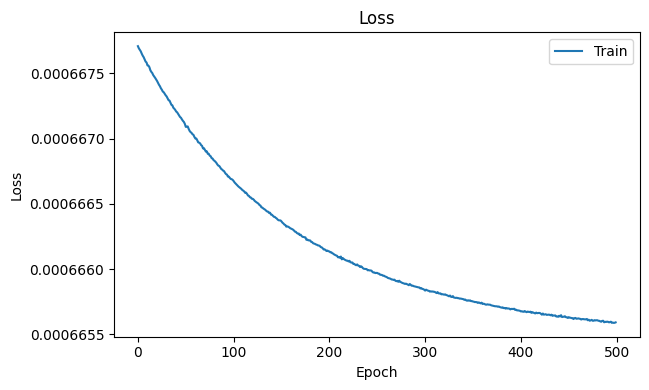

In [125]:
average_train_loss_per_sample = [loss_item / len(train_dataloader) for loss_item in train_loss]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(len(average_train_loss_per_sample)), average_train_loss_per_sample)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'])
plt.tight_layout()
plt.show()

In [126]:
num_mc_samples = 10000
predicted_values = []
actual_values = []
probabilities_values = []
confidence_interval_dict = {}
confidence_interval_dict["real"] = {}
confidence_interval_dict["imaginary"] = {}
model.eval()

with torch.no_grad():
    for i, inputs in enumerate(test_dataloader):
        all_predictions_real = []
        all_predictions_imaginary = []
        inputs = [inp.to(device) for inp in inputs]
        permittivity_real, permittivity_imaginary, frequency, orientation, \
        s11_real, s11_imaginary, s12_real, s12_imaginary, \
        s21_real, s21_imaginary, s22_real, s22_imaginary = inputs
        input_features = torch.cat([frequency.unsqueeze(2),
                                    orientation.unsqueeze(2),
                                    s11_real.unsqueeze(2),
                                    s11_imaginary.unsqueeze(2),
                                    s12_real.unsqueeze(2),
                                    s12_imaginary.unsqueeze(2),
                                    s21_real.unsqueeze(2),
                                    s21_imaginary.unsqueeze(2),
                                    s22_real.unsqueeze(2),
                                    s22_imaginary.unsqueeze(2)], dim=2)
        raw_predictions = model(input_features)
        raw_predictions_real = raw_predictions[0, 0]
        raw_predictions_imaginary = raw_predictions[0, 1]
        permittivity_real_actual = permittivity_real[0][0]
        permittivity_imaginary_actual = permittivity_imaginary[0][0]
        predicted_values.append((raw_predictions_real.item(), raw_predictions_imaginary.item()))
        actual_values.append((permittivity_real_actual.item(), permittivity_imaginary_actual.item()))

        for _ in range(num_mc_samples):
            boot_strap_prediction = model(input_features, apply_dropout=True)
            boot_strap_predictions_real = boot_strap_prediction[0, 0]
            boot_strap_predictions_imaginary = boot_strap_prediction[0, 1]
            all_predictions_real.append(boot_strap_predictions_real)
            all_predictions_imaginary.append(boot_strap_predictions_imaginary)

        all_predictions_real.append(raw_predictions_real)
        all_predictions_imaginary.append(raw_predictions_imaginary)
        all_predictions_real = torch.stack(all_predictions_real)
        all_predictions_imaginary = torch.stack(all_predictions_imaginary)

        mean_predictions_real = torch.mean(all_predictions_real, dim=0)
        lower_bound_real, _ = torch.kthvalue(all_predictions_real, int(0.1 * num_mc_samples), dim=0)
        upper_bound_real, _ = torch.kthvalue(all_predictions_real, int(0.90 * num_mc_samples), dim=0)

        mean_predictions_imaginary = torch.mean(all_predictions_imaginary, dim=0)
        lower_bound_imaginary, _ = torch.kthvalue(all_predictions_imaginary, int(0.1 * num_mc_samples), dim=0)
        upper_bound_imaginary, _ = torch.kthvalue(all_predictions_imaginary, int(0.9 * num_mc_samples), dim=0)

        mean_predictions_real = mean_predictions_real.detach().cpu().numpy()
        lower_bound_real = lower_bound_real.detach().cpu().numpy()
        upper_bound_real = upper_bound_real.detach().cpu().numpy()

        mean_predictions_imaginary = mean_predictions_imaginary.detach().cpu().numpy()
        lower_bound_imaginary = lower_bound_imaginary.detach().cpu().numpy()
        upper_bound_imaginary = upper_bound_imaginary.detach().cpu().numpy()

        confidence_interval_dict["real"][i] = (mean_predictions_real, lower_bound_real, upper_bound_real)
        confidence_interval_dict["imaginary"][i] = (mean_predictions_imaginary, lower_bound_imaginary, upper_bound_imaginary)

predicted_values = np.array(predicted_values)
actual_values = np.array(actual_values)

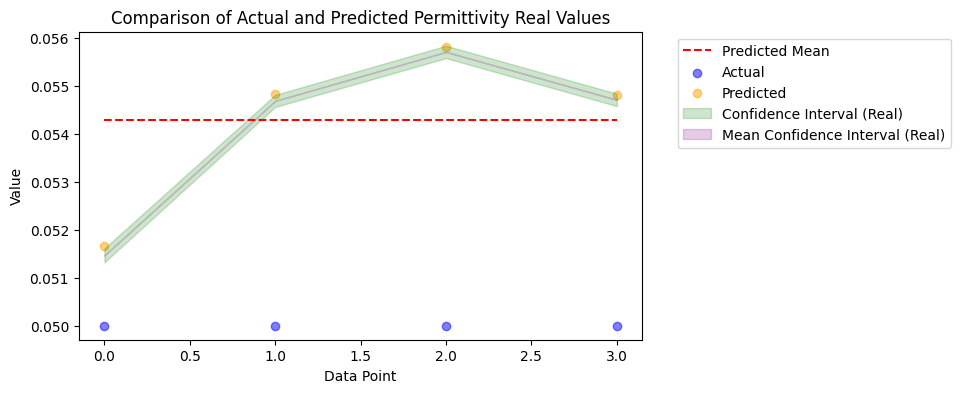

In [129]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 0]), np.mean(predicted_values[:, 0])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 0], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 0], label='Predicted', color='orange', alpha=0.5)
mean_predictions_real, lower_bound_real, upper_bound_real = zip(*confidence_interval_dict["real"].values())
mean_predictions_real = np.array(mean_predictions_real)
lower_bound_real = np.array(lower_bound_real)
upper_bound_real = np.array(upper_bound_real)
plt.fill_between(range(len(actual_values)), lower_bound_real, upper_bound_real, color='green', alpha=0.2, label='Confidence Interval (Real)')
plt.fill_between(range(len(actual_values)), mean_predictions_real, mean_predictions_real, color='purple', alpha=0.2, label='Mean Confidence Interval (Real)')
plt.title('Comparison of Actual and Predicted Permittivity Real Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


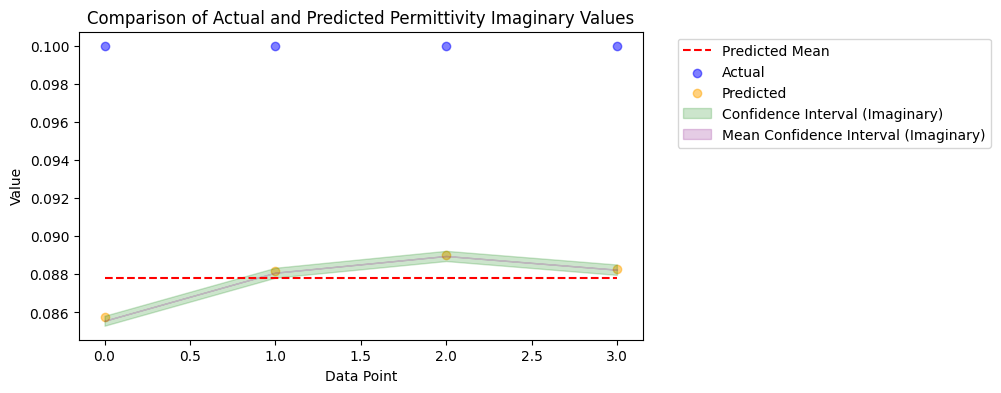

In [130]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot([0, len(actual_values) - 1], [np.mean(predicted_values[:, 1]), np.mean(predicted_values[:, 1])], label='Predicted Mean', color='red', linestyle='dashed')
plt.scatter(range(len(actual_values)), actual_values[:, 1], label='Actual', color='blue', alpha=0.5)
plt.scatter(range(len(actual_values)), predicted_values[:, 1], label='Predicted', color='orange', alpha=0.5)
mean_predictions_imaginary, lower_bound_imaginary, upper_bound_imaginary = zip(*confidence_interval_dict["imaginary"].values())
mean_predictions_imaginary = np.array(mean_predictions_imaginary)
lower_bound_imaginary = np.array(lower_bound_imaginary)
upper_bound_imaginary = np.array(upper_bound_imaginary)
plt.fill_between(range(len(actual_values)), lower_bound_imaginary, upper_bound_imaginary, color='green', alpha=0.2, label='Confidence Interval (Imaginary)')
plt.fill_between(range(len(actual_values)), mean_predictions_imaginary, mean_predictions_imaginary, color='purple', alpha=0.2, label='Mean Confidence Interval (Imaginary)')
plt.title('Comparison of Actual and Predicted Permittivity Imaginary Values')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()